# Clase 8 - YOLO

https://github.com/Garima13a/YOLO-Object-Detection

YOLO (You only look once) es un sistema de detección de objetos que puede ser usado en tiempo real. Antes de YOLO, la mayoría de los métodos de detección de objetos usaban pipelines compuestos de varias partes como redes neuronales para generar potenciales *bounding boxes*, clasificadores para hacer predicciones sobre esas *boxes*, etc. YOLO es una sola red neuronal que se encarga de todo. 

La idea es dividir la imagen en una grilla de $SxS$ regiones, y que cada una de estas regiones se encargue de predecir posibles *bounding boxes* y probabilidades de pertenecer a una clase mediante una regresión.

YOLO usa Darknet, una libreria open source escrita en c y CUDA.

![](img/yolo.png)

Imagen sacada del [primer paper](https://arxiv.org/pdf/1506.02640.pdf) de YOLO.

In [1]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

Cargamos la arquitectura y los pesos de la red de los archivos *yolov3.cfg* y *yolov3.weights* respectivamente.
El archivo *coco.names* tiene el nombre de las clases sobre las que están entrenados los pesos.

In [2]:
# Set the location and name of the cfg file
cfg_file = './data/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './data/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

## Arquitectura de CNN
Normalmente las CNN en su arquitectura tiene una primera parte compuesta por capas convolucionales y de pooling, llamada feature extractor y al parte de clasificación compuesta por capas densas.

![](images/cnn.jpeg)

Observamos la arquitectura de la red YOLO

In [3]:
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

![](images/yolo_arch.png)

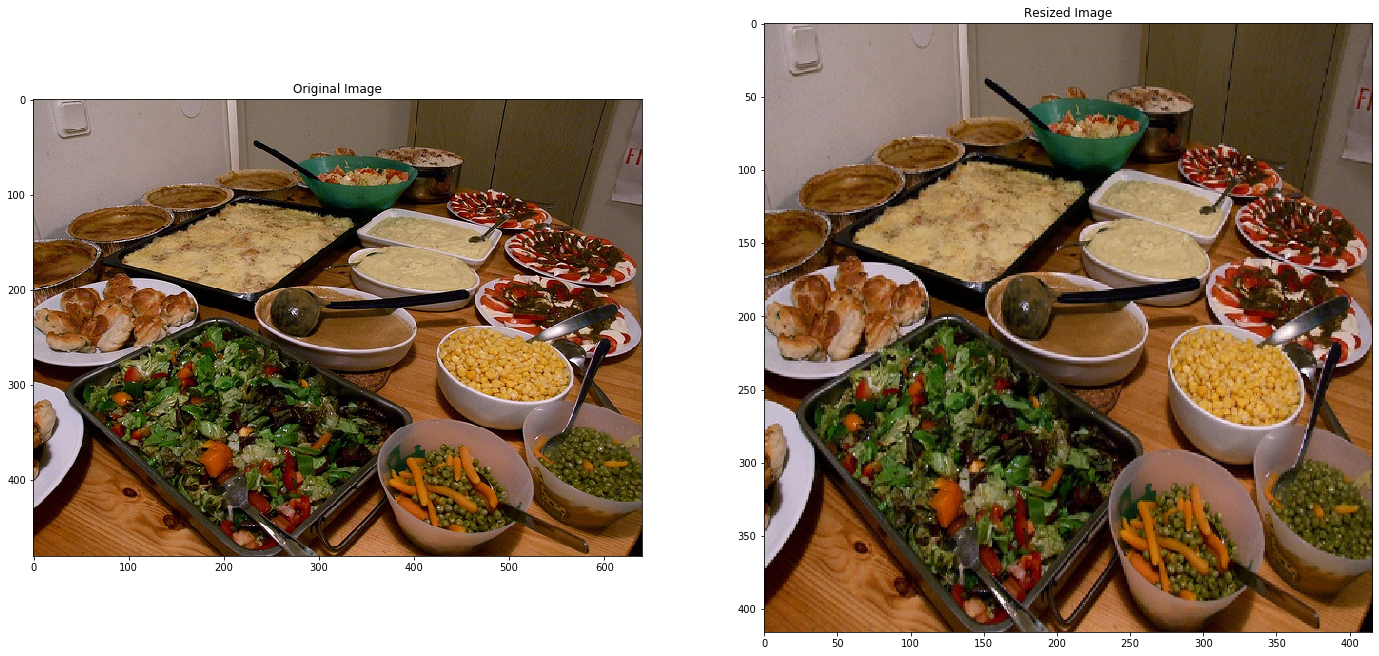

In [4]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]

img = cv2.imread('./images/food.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression Threshold

As you learned in the previous lessons, YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  In the code below, we set this NMS threshold to `0.6`. This means that all predicted bounding boxes that have a detection probability less than 0.6 will be removed. 

# Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold. In the code below, we set this IOU threshold to `0.4`. This means that all predicted bounding boxes that have an IOU value greater than 0.4 with respect to the best bounding boxes will be removed.

In the `utils` module you will find the `nms` function, that performs the second step of Non-Maximal Suppression, and the `boxes_iou` function that calculates the Intersection over Union of two given bounding boxes. You are encouraged to look at these functions to see how they work. 

# Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for `nms_thresh` and `iou_thresh`, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. This function takes in the model `m` returned by *Darknet*, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. Since we are running the algorithm on a CPU it takes about 2 seconds to detect the objects in an image, however, if we were to use a GPU it would run much faster.

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the `plot_labels` flag to `False` you will display the bounding boxes with no labels. This makes it easier to view the bounding boxes if your `nms_thresh` is too low. The `plot_boxes()`function uses the same color to plot the bounding boxes of the same object class. However, if you want all bounding boxes to be the same color, you can use the `color` keyword to set the desired color. For example, if you want all the bounding boxes to be red you can use:

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))`

You are encouraged to change the `iou_thresh` and `nms_thresh` parameters to see how they affect the YOLO detection algorithm. The default values of `iou_thresh = 0.4` and `nms_thresh = 0.6` work well to detect objects in different kinds of images. In the cell below, we have repeated some of the code used before in order to prevent you from scrolling up down when you want to change the `iou_thresh` and `nms_thresh`parameters or the image. Have Fun!



It took 1.316 seconds to detect the objects in the image.

Number of Objects Detected: 17 

Objects Found and Confidence Level:

1. bowl: 0.999978
2. bowl: 0.999683
3. bowl: 0.999968
4. bowl: 0.999995
5. spoon: 0.996658
6. bowl: 0.999998
7. bowl: 0.999983
8. spoon: 0.999949
9. diningtable: 0.999985
10. bowl: 0.999991
11. bowl: 0.999346
12. spoon: 0.999407
13. spoon: 0.943998
14. bowl: 0.999959
15. carrot: 0.999987
16. carrot: 1.000000
17. carrot: 0.999996


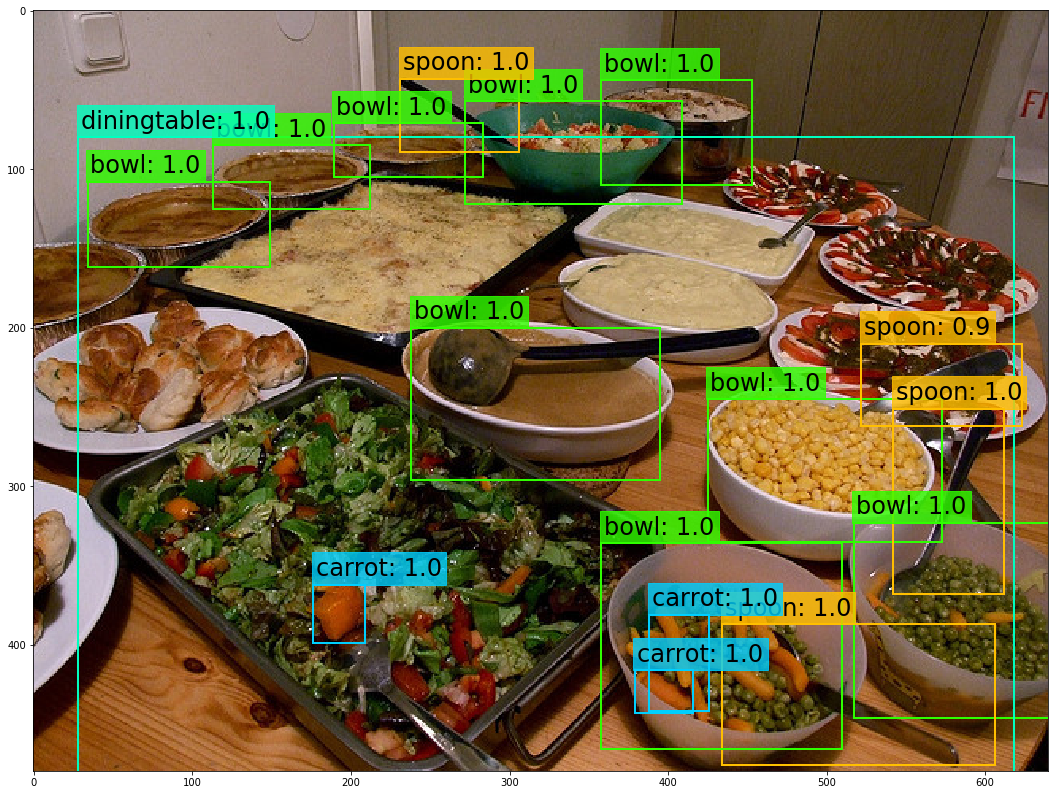

In [5]:
plt.rcParams['figure.figsize'] = [24.0, 14.0]
img = cv2.imread('./images/food.jpg')
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)